In [218]:

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from scipy.ndimage import gaussian_filter
import tqdm
from collections import Counter
np.random.seed(1)

In [219]:
strike_zone_width = 17.0 + 2.9 # plate width + margin (one ball width on each side)
strike_zone_height = strike_zone_width * 1.2
strike_zone = [-strike_zone_width/2, strike_zone_width/2, -strike_zone_height/2, strike_zone_height/2] # left, right, bottom, top

bins = 10
x_bin = np.linspace(-40, 40, bins+1, endpoint=True)
y_bin = np.linspace(-45, 45, bins+1, endpoint=True)
x_centers = 0.5 * (x_bin[:-1] + x_bin[1:])
y_centers = 0.5 * (y_bin[:-1] + y_bin[1:])

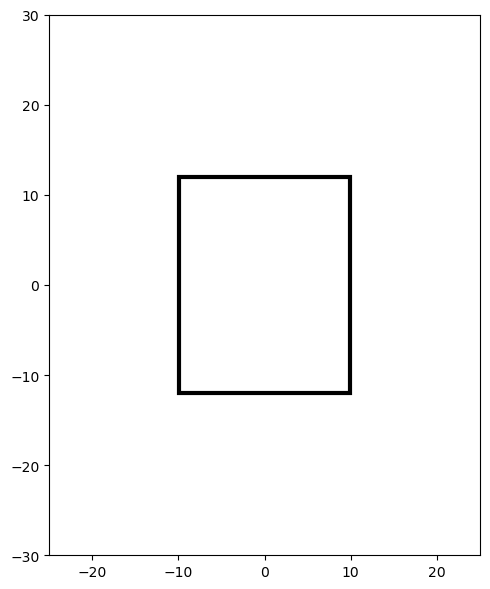

In [220]:
fig, ax = plt.subplots(1, 1, figsize=(5,6), tight_layout=True)


def plotting_background():
    # ax.axhline(0, color='black', linestyle='--', linewidth=1)
    # ax.axvline(0, color='black', linestyle='--', linewidth=1)
    # ax.set_title(f'Pitch Location Map ({type})')
    # ax.set_xlabel('Horizontal Location (inch)')
    # ax.set_ylabel('Vertical Location (inch)')
    ax.add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                        linewidth=3, edgecolor='k', facecolor='none', linestyle='-', label='Strike Zone'))
    # ax.grid(True)
    ax.set_xlim(-25, 25)
    ax.set_ylim(-30, 30)
plotting_background()
plt.show()

In [221]:


def summarize_sequences(sequences, title):
    """Analyzes and prints the most common pitch sequences and their average locations."""
    if not sequences:
        print(f"\n--- {title} ---")
        print("No sequences to analyze.")
        return

    # Extract the sequence of pitch types for each PA
    pitch_sequences = [tuple(pitch['pitch_type'] for pitch in pa['sequence']) for pa in sequences]
    
    # Count the frequency of each unique sequence
    sequence_counts = Counter(pitch_sequences)
    
    total_sequences = len(sequences)
    
    print(f"\n--- {title} (Top 5) ---")
    print(f"Total of {total_sequences} PAs analyzed.")
    
    # Display the top 5 most common sequences
    for sequence, count in sequence_counts.most_common(5):
        percentage = (count / total_sequences) * 100
        sequence_str = " -> ".join(sequence)
        print(f"\n  - Sequence: {sequence_str}")
        print(f"    Frequency: {count} times ({percentage:.1f}%)")

        # Find all PAs that match this sequence
        matching_pas = [pa for pa in sequences if tuple(p['pitch_type'] for p in pa['sequence']) == sequence]
        
        # Initialize lists to store locations for each pitch in the sequence
        locations_by_pitch = [[] for _ in sequence]
        
        # Collect locations
        for pa in matching_pas:
            for i, pitch in enumerate(pa['sequence']):
                if i < len(locations_by_pitch):
                    locations_by_pitch[i].append(pitch['location'])
        
        # Calculate and print average location for each pitch
        print("    Average Locations (X, Y):")
        for i, locations in enumerate(locations_by_pitch):
            if locations:
                avg_location = np.mean(locations, axis=0)
                print(f"      Pitch {i+1} ({sequence[i]}): ({avg_location[0]:.1f}, {avg_location[1]:.1f})")



In [222]:
load_file = 'kent_results.csv'


# --- Load and Reconstruct Sequences from CSV ---
# Load the simulation results from the CSV file
results_df = pd.read_csv(load_file)
print(f"Loaded simulation data from '{load_file}'")

# Reconstruct the sequence data structure from the flat CSV
good_sequences_from_csv = []
bad_sequences_from_csv = []

# Group by 'pa_id' to process each plate appearance individually
for pa_id, pa_group in results_df.groupby('pa_id'):
    # Sort pitches within the PA to ensure they are in the correct order
    pa_group = pa_group.sort_values('pitch_num')
    
    # Recreate the list of pitch dictionaries for the sequence
    sequence = [
        {
            'pitch_type': row['pitch_type'],
            'location': (row['location_x'], row['location_y']),
            'count': row['count'],
            'outcome': row['pitch_outcome']
        } for _, row in pa_group.iterrows()
    ]
    
    # Recreate the full PA dictionary
    pa_reconstructed = {
        'sequence': sequence,
        'final_outcome': pa_group['pa_final_outcome'].iloc[0]
    }
    
    # Append the reconstructed PA to the appropriate list based on its type
    if pa_group['pa_type'].iloc[0] == 'Good':
        good_sequences_from_csv.append(pa_reconstructed)
    else:
        bad_sequences_from_csv.append(pa_reconstructed)



# --- Function to get random location within a bin ---
def get_random_location_in_bin(center_x, center_y):
    """
    Finds the bin corresponding to the center coordinates and returns a random
    location within that bin's boundaries.
    """
    # Find the index of the bin for x and y coordinates
    # np.isclose is used to handle potential floating point inaccuracies
    x_index = np.where(np.isclose(x_centers, center_x))[0]
    y_index = np.where(np.isclose(y_centers, center_y))[0]
    
    # Check if a unique bin was found
    if len(x_index) == 1 and len(y_index) == 1:
        ix = x_index[0]
        iy = y_index[0]
        
        # Get the boundaries of the bin
        x_min, x_max = x_bin[ix], x_bin[ix+1]
        y_min, y_max = y_bin[iy], y_bin[iy+1]
        
        # Generate a random location within these boundaries
        random_x = np.random.uniform(x_min, x_max)
        random_y = np.random.uniform(y_min, y_max)
        
        return (random_x, random_y)
    else:
        # If the bin center is not found, return the original center as a fallback
        return (center_x, center_y)

# --- Overwrite the location data with randomized locations within each bin ---
print("\nRandomizing pitch locations within their respective bins...")

# Process good sequences
for pa in good_sequences_from_csv:
    for pitch in pa['sequence']:
        center_x, center_y = pitch['location']
        pitch['location'] = get_random_location_in_bin(center_x, center_y)

# Process bad sequences
for pa in bad_sequences_from_csv:
    for pitch in pa['sequence']:
        center_x, center_y = pitch['location']
        pitch['location'] = get_random_location_in_bin(center_x, center_y)

print("Location randomization complete.")


Loaded simulation data from 'kent_results.csv'

Randomizing pitch locations within their respective bins...
Location randomization complete.


In [223]:

# --- Summarize and Display Results from CSV data ---
summarize_sequences(good_sequences_from_csv, "Most Frequent 'Good' Pitch Sequences (from CSV)")
summarize_sequences(bad_sequences_from_csv, "Most Frequent 'Bad' Pitch Sequences (from CSV)")


--- Most Frequent 'Good' Pitch Sequences (from CSV) (Top 5) ---
Total of 512 PAs analyzed.

  - Sequence: Fastball -> Fastball -> Offspeed
    Frequency: 60 times (11.7%)
    Average Locations (X, Y):
      Pitch 1 (Fastball): (3.4, -0.7)
      Pitch 2 (Fastball): (8.3, -2.3)
      Pitch 3 (Offspeed): (-3.8, -5.1)

  - Sequence: Fastball -> Offspeed -> Offspeed
    Frequency: 35 times (6.8%)
    Average Locations (X, Y):
      Pitch 1 (Fastball): (4.9, -0.2)
      Pitch 2 (Offspeed): (-0.5, -4.4)
      Pitch 3 (Offspeed): (-4.8, -2.6)

  - Sequence: Fastball -> Fastball -> Fastball
    Frequency: 35 times (6.8%)
    Average Locations (X, Y):
      Pitch 1 (Fastball): (2.6, -0.7)
      Pitch 2 (Fastball): (8.7, -3.5)
      Pitch 3 (Fastball): (9.8, -1.4)

  - Sequence: Fastball -> Fastball -> Breaking
    Frequency: 21 times (4.1%)
    Average Locations (X, Y):
      Pitch 1 (Fastball): (1.5, 0.2)
      Pitch 2 (Fastball): (7.8, -3.1)
      Pitch 3 (Breaking): (7.1, -7.3)

  - Sequence

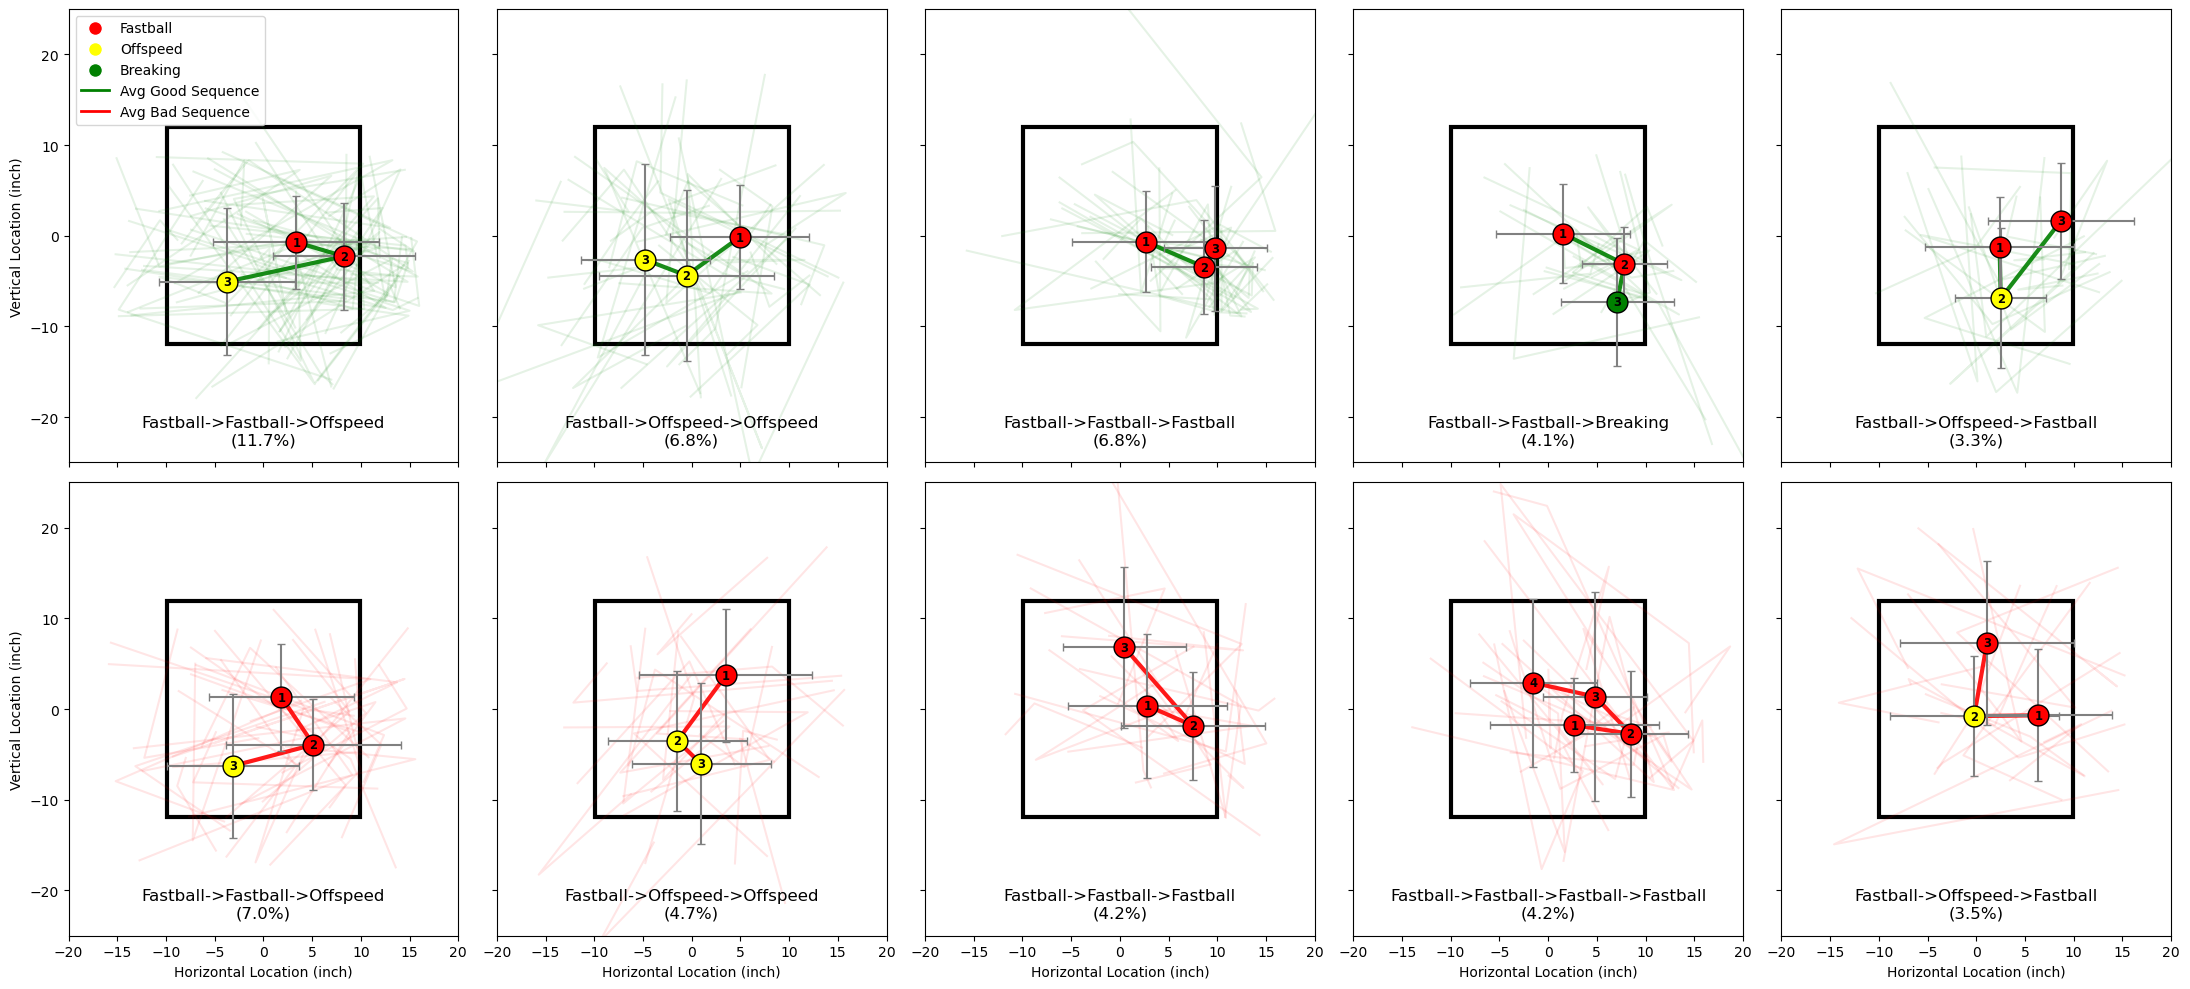

In [224]:
from matplotlib.lines import Line2D

# Create a figure with 10 subplots (2 rows for good/bad, 5 columns for ranks)
fig, axes = plt.subplots(2, 5, figsize=(22, 10), sharey=True, sharex=True, tight_layout=True)
# fig.suptitle("Top 5 Average Pitch Sequences (Good vs. Bad)", fontsize=16, y=1.02)
plt.subplots_adjust(wspace=0.0, hspace=0.0)

# Define a color map for pitch types
pitch_color_map = {
    'Fastball': 'red',
    'Offspeed': 'yellow',
    'Breaking': 'green'
}

def plot_average_sequence(ax, sequences, target_sequence, line_style, line_label):
    """Finds matching sequences, calculates their average, and plots it on a given axis."""
    
    # Find all PAs that match the target sequence
    matching_locations = []
    for pa in sequences:
        pitch_types = tuple(pitch['pitch_type'] for pitch in pa['sequence'])
        if pitch_types == target_sequence:
            locations = [pitch['location'] for pitch in pa['sequence']]
            matching_locations.append(locations)

    # If any matching sequences were found, calculate and plot the average
    if matching_locations:
        line_color = line_style[0]  # 'g' from 'g-' or 'r' from 'r--'
        
        # Plot all individual sequences with high transparency
        for locations in matching_locations:
            loc_array = np.array(locations)
            ax.plot(loc_array[:, 0], loc_array[:, 1], color=line_color, linestyle='-', alpha=0.1, zorder=1)

        # Calculate the average and standard deviation for each pitch in the sequence
        locations_array = np.array(matching_locations)
        avg_locations = np.mean(locations_array, axis=0)
        std_locations = np.std(locations_array, axis=0)
        
        avg_x = avg_locations[:, 0]
        avg_y = avg_locations[:, 1]
        x_err = std_locations[:, 0]
        y_err = std_locations[:, 1]
        
        # Plot the average line connecting the pitches, make it more prominent
        ax.plot(avg_x, avg_y, line_style, alpha=0.9, label=f"{line_label}", linewidth=3, zorder=3)
        
        # Plot colored markers for each pitch in the average sequence with error bars
        for i, pitch_type in enumerate(target_sequence):
            color = pitch_color_map.get(pitch_type, 'black') # Default to black if type not in map
            ax.errorbar(avg_x[i], avg_y[i], xerr=x_err[i], yerr=y_err[i],
                        fmt='o', color=color, ecolor='gray', elinewidth=1.5, capsize=3,
                        markeredgecolor='k', markersize=15, zorder=5)
            # Add a number on the dot to denote the order
            ax.text(avg_x[i], avg_y[i], str(i + 1),
                    color='black', ha='center', va='center',
                    fontsize='small', fontweight='bold', zorder=6)
        return True
    return False


# --- Get Top 5 Good and Bad Sequences ---
good_sequence_counts = Counter(tuple(p['pitch_type'] for p in pa['sequence']) for pa in good_sequences_from_csv)
top_5_good = good_sequence_counts.most_common(5)

bad_sequence_counts = Counter(tuple(p['pitch_type'] for p in pa['sequence']) for pa in bad_sequences_from_csv)
top_5_bad = bad_sequence_counts.most_common(5)


# --- Plot Top 5 Good Sequences on the Top Row ---
for i, ax in enumerate(axes[0]):
    # Redraw the background for each subplot
    ax.add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                        linewidth=3, edgecolor='k', facecolor='none', linestyle='-'))
    ax.set_xlim(-20, 20)
    ax.set_ylim(-25, 25)
    # ax.set_title(f"Rank {i+1}")
    if i == 0:
        ax.set_ylabel('Vertical Location (inch)')

    # Plot the i-th most common good sequence
    if i < len(top_5_good):
        good_seq, good_count = top_5_good[i]
        plot_average_sequence(ax, good_sequences_from_csv, good_seq, 'g-', 'Avg Good')
        title_part = f"{'->'.join(good_seq)}\n({good_count/len(good_sequences_from_csv)*100:.1f}%)"
        ax.text(0, -23, title_part, fontsize=12, ha='center')

# --- Plot Top 5 Bad Sequences on the Bottom Row ---
for i, ax in enumerate(axes[1]):
    # Redraw the background for each subplot
    ax.add_patch(plt.Rectangle((strike_zone[0], strike_zone[2]), strike_zone_width, strike_zone_height,
                        linewidth=3, edgecolor='k', facecolor='none', linestyle='-'))
    ax.set_xlim(-20, 20)
    ax.set_ylim(-25, 25)
    ax.set_xlabel('Horizontal Location (inch)')
    if i == 0:
        ax.set_ylabel('Vertical Location (inch)')

    # Plot the i-th most common bad sequence
    if i < len(top_5_bad):
        bad_seq, bad_count = top_5_bad[i]
        plot_average_sequence(ax, bad_sequences_from_csv, bad_seq, 'r-', 'Avg Bad')
        title_part = f"{'->'.join(bad_seq)}\n({bad_count/len(bad_sequences_from_csv)*100:.1f}%)"
        ax.text(0, -23, title_part, fontsize=12, ha='center')


# Create custom legend for pitch type colors and sequence types
legend_elements = [Line2D([0], [0], marker='o', color='w', label='Fastball', markerfacecolor='red', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Offspeed', markerfacecolor='yellow', markersize=10),
                   Line2D([0], [0], marker='o', color='w', label='Breaking', markerfacecolor='green', markersize=10),
                   Line2D([0], [0], color='g', lw=2, label='Avg Good Sequence'),
                   Line2D([0], [0], color='r', lw=2, label='Avg Bad Sequence')]

# Place legend on the first subplot of the top row
axes[0, 0].legend(handles=legend_elements, loc='upper left', fontsize='medium')

plt.savefig(f"{os.path.splitext(load_file)[0]}.png", dpi=300, bbox_inches='tight')
plt.show()
